In [25]:
import glob
import numpy as np

In [26]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [27]:
# dats = dats[1:]
# frds = frds[1:]

In [28]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [29]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [30]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [31]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [32]:
design = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["SX","SY","X","Y"] ]

In [33]:
from gmshtools.grid_section import grid_section
from matplotlib import pyplot as plt

In [34]:
%matplotlib ipympl

In [35]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [36]:
ifrd = readfrd(frds[0])
idesign = design[0]


In [37]:
data = ifrd["data"]

In [38]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

data = data[data["x"] > xmin]
data = data[data["x"] < xmax]
data = data[data["y"] > ymin]
data = data[data["y"] < ymax]


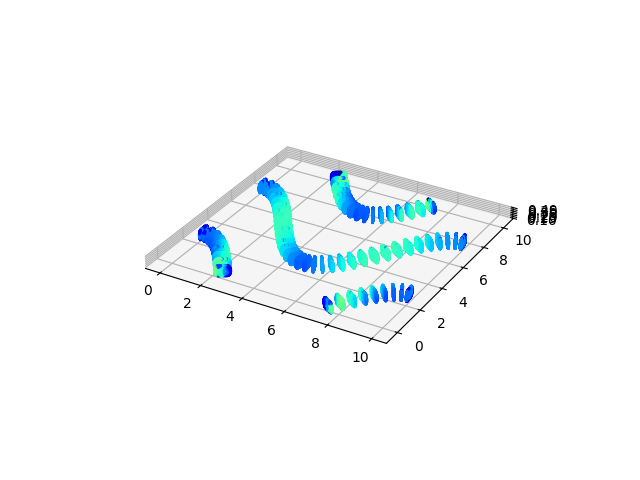

In [39]:
# neartest neighbor interpolation
from scipy.interpolate import NearestNDInterpolator


x = data["x"]
y = data["y"]
z = data["z"]
P1 = data["P1"]

fcn = NearestNDInterpolator((x,y,z),P1)

d = params_composite["d"]
r = params_composite["r"]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']
for jj,jtrajs in enumerate(idesign):

    jtraj_diff = np.diff(jtrajs,axis=0)

    for j in range(0,len(jtraj_diff),600):

        vec_z =  jtraj_diff[j]
        vec_z = vec_z/np.linalg.norm(vec_z)
        vec_x = np.cross(vec_z, [0,0,1])
        vec_x = vec_x/np.linalg.norm(vec_x)

        X,Y,Z = grid_section(jtrajs[j][0],
                            jtrajs[j][1],
                            jtrajs[j][2],
                            vec_z,
                            vec_x,
                            0.8*d,
                            0.8*r,
                            rho=150)
        Z = Z + params_composite["h"]/2
        P1 = fcn(X,Y,Z)
        P1
        # ax.plot(X,Y,Z, alpha=0.5, color=colors[jj])
        ax.scatter(X,Y,Z, c=P1, alpha=0.5, marker='o', s=1, cmap='jet',vmin=0, vmax=1000)
# aspect ratio 
plt.gca().set_box_aspect([1,1,0.05])  # aspect ratio is 1:1:1

In [40]:
ifrd = readfrd(frds[0])


In [41]:
# neartest neighbor interpolation
from scipy.interpolate import NearestNDInterpolator

P1_time_design = []
Sapl_list_design = []
for ii in range(4):

    idesign = design[ii]
    ifrd = readfrd(frds[ii])


    P1_time = []
    Sapl_list = []

    for data in ifrd["data_blocks"]:


        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)

        data = data[data["x"] > xmin]
        data = data[data["x"] < xmax]
        data = data[data["y"] > ymin]
        data = data[data["y"] < ymax]

        x = data["x"]
        y = data["y"]
        z = data["z"]
        P1 = data["P1"]

        fcn = NearestNDInterpolator((x,y,z),P1)

        d = params_composite["d"]
        r = params_composite["r"]

        P1_mu_list = []
        for jj,jtrajs in enumerate(idesign):

            jtraj_diff = np.diff(jtrajs,axis=0)

            for j in range(0,len(jtraj_diff),600):

                vec_z =  jtraj_diff[j]
                vec_z = vec_z/np.linalg.norm(vec_z)
                vec_x = np.cross(vec_z, [0,0,1])
                vec_x = vec_x/np.linalg.norm(vec_x)

                X,Y,Z = grid_section(jtrajs[j][0],
                                    jtrajs[j][1],
                                    jtrajs[j][2],
                                    vec_z,
                                    vec_x,
                                    0.8*d,
                                    0.8*r,
                                    rho=150)
                Z = Z + params_composite["h"]/2
                P1 = fcn(X,Y,Z)
                P1_mu = np.mean(P1)
                P1_mu_list.append(P1_mu)

            # ============================



        P1_max = np.max(P1_mu_list)
        P1_time.append(P1_max)
        
    P1_time_design.append(P1_time)
    Sapl_list_design.append(Sapl_list)

In [42]:
Sapl_list_design[0]

[np.float64(0.0),
 np.float64(56.43239871956173),
 np.float64(112.86480552634521)]

In [43]:
P1_time_design[0]

[np.float64(0.0),
 np.float64(210.88860544558725),
 np.float64(421.7772414287649)]

In [44]:
%matplotlib inline

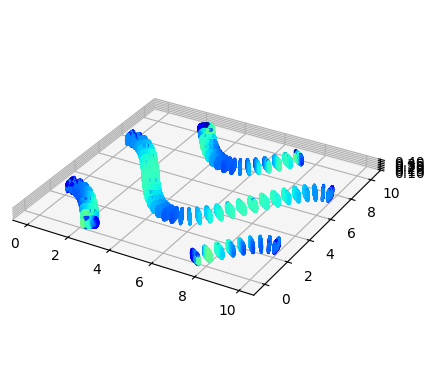

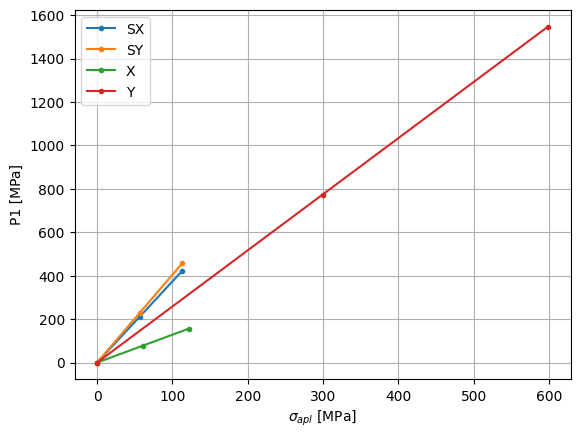

In [45]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [46]:
ratio = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio = {
    "SX": ratio[0],
    "SY": ratio[1],
    "X":  ratio[2],
    "Y":  ratio[3]
}
ratio

{'SX': np.float64(3.7370129639776195),
 'SY': np.float64(4.046305929413829),
 'X': np.float64(1.2844055304827087),
 'Y': np.float64(2.5841400155862795)}

In [47]:
ratio

{'SX': np.float64(3.7370129639776195),
 'SY': np.float64(4.046305929413829),
 'X': np.float64(1.2844055304827087),
 'Y': np.float64(2.5841400155862795)}

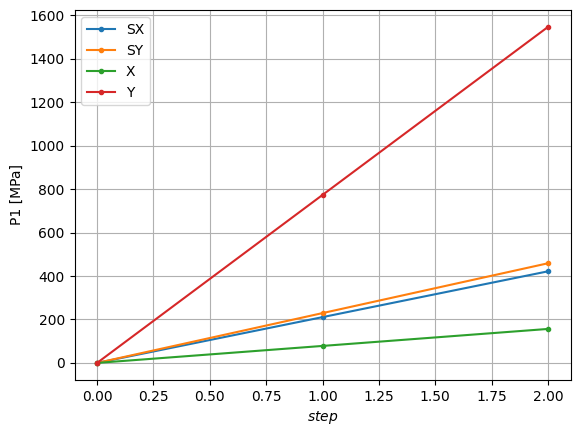

In [48]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$step$")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  